In [1]:
from getpass import getpass
import os
from dotenv import load_dotenv

# 載入環境變數
load_dotenv()
# 兩個 API 的密鑰
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPERDEV_API_KEY"] = os.getenv("SERPERDEV_API_KEY")
# 判斷是否存在，不存在可透過手動輸入
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")
if "SERPERDEV_API_KEY" not in os.environ:
    os.environ["SERPERDEV_API_KEY"] = getpass("Enter Serper API key:")

In [45]:
# 用於建立文件
from haystack.dataclasses import Document

# 定義一個文件，內容描述了德國南部巴伐利亞州首府慕尼黑
documents = [
    Document(
        content="""慕尼黑是德國南部巴伐利亞州的首府，充滿了豐富的文化遺產和現代城市的優雅。位於伊薩爾河畔，慕尼黑以其華麗的建築而聞名，如馬麗恩廣場的慕尼黑新市政廳和寧芬堡宮的宏偉壯觀。這座城市是藝術愛好者的天堂，擁有世界級的博物館，如阿爾特·皮納科特克，收藏了許多著名藝術家的傑作。慕尼黑也因其熱鬧的啤酒花園而聞名，當地人和遊客聚集在這裡享受城市著名的啤酒和傳統巴伐利亞美食。每年的慕尼黑啤酒節是世界上最大的啤酒節，吸引了來自世界各地的數百萬遊客。除了豐富的文化和美食享受外，慕尼黑還擁有如英國花園這樣的美麗公園，為繁忙的都市提供了一個寧靜的避風港。遊客們為慕尼黑的熱情好客所打動，使得這裡成為了想要體驗古老魅力和現代魅力的旅行者必去的目的地。"""
    )
]

In [3]:
# 定義一個提示模板，指導 LLM 回答查詢
prompt_template = """
根據文件回答下列問題。
如果答案未包含在文件中，請回覆
'no_answer'

Query: {{query}}

Documents:
{% for document in documents %}
    {{document.content}}
{% endfor %}
"""

In [4]:
from haystack.components.builders.prompt_builder import PromptBuilder
# 使用定義的模板建立 PromptBuilder
prompt_builder = PromptBuilder(template=prompt_template)

In [5]:
from haystack.components.generators import OpenAIGenerator
# 初始化 OpenAIGenerator，使用 gpt-4-turbo 模型
llm = OpenAIGenerator(model="gpt-4-turbo")

In [6]:
# 定義一個提示模板，用於網絡搜索
prompt_for_websearch = """
根據從 Web 檢索到的文件，回答以下查詢。
你的答案應表明你的答案是透過網路搜尋產生的。

Query: {{query}}
Documents:
{% for document in documents %}
    {{document.content}}
{% endfor %}
"""

In [7]:
from haystack.components.websearch.serper_dev import SerperDevWebSearch

# 初始化網絡搜索組件
websearch = SerperDevWebSearch()

In [8]:
from haystack.components.builders.prompt_builder import PromptBuilder
# 使用網絡搜索提示模板建立 PromptBuilder
prompt_builder_for_websearch = PromptBuilder(template=prompt_for_websearch)

In [9]:
from haystack.components.generators import OpenAIGenerator
# 初始化 OpenAIGenerator，使用 gpt-4-turbo 模型
llm_for_websearch = OpenAIGenerator(model="gpt-4-turbo")

In [10]:
from haystack.components.routers import ConditionalRouter

# 定義路由規則
routes = [
    {
        # 如果 LLM 回覆中包含 'no_answer'
        "condition": "{{'no_answer' in replies[0]}}",
        # 將查詢作為輸出
        "output": "{{query}}",
        # 輸出名稱
        "output_name": "go_to_websearch",
        # 輸出類型
        "output_type": str
    },
    {
        # 如果 LLM 回覆中不包含 'no_answer'
        "condition": "{{'no_answer' not in replies[0]}}",
        # 將回覆的答案作為輸出
        "output": "{{replies[0]}}",
        # 輸出名稱
        "output_name": "answer",
        # 輸出類型
        "output_type": str
    }
]

# 初始化 ConditionalRouter
router = ConditionalRouter(routes)

In [11]:
from haystack import Pipeline

# 建立管道
pipe = Pipeline()

In [12]:
# 添加組件到管道
pipe.add_component("prompt_builder", prompt_builder)
pipe.add_component("llm", llm)
pipe.add_component("router", router)
pipe.add_component("websearch", websearch)
pipe.add_component("prompt_builder_for_websearch", prompt_builder_for_websearch)
pipe.add_component("llm_for_websearch", llm_for_websearch)

In [13]:
# 連接管道中的組件
# 連接 prompt_builder 到 llm
pipe.connect(
    "prompt_builder", "llm"
)
# 連接 llm 的回覆到 router
pipe.connect(
    "llm.replies", "router.replies"
)
# 連接 router 的 go_to_websearch 到 websearch 的查詢
pipe.connect(
    "router.go_to_websearch", "websearch.query"
)
# 連接 router 的 go_to_websearch 到 prompt_builder_for_websearch 的查詢
pipe.connect(
    "router.go_to_websearch", "prompt_builder_for_websearch.query"
)
# 連接 websearch 的文件到 prompt_builder_for_websearch
pipe.connect(
    "websearch.documents", "prompt_builder_for_websearch.documents"
)
# 連接 prompt_builder_for_websearch 到 llm_for_websearch
pipe.connect(
    "prompt_builder_for_websearch", "llm_for_websearch"
)

🚅 Components
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
  - router: ConditionalRouter
  - websearch: SerperDevWebSearch
  - prompt_builder_for_websearch: PromptBuilder
  - llm_for_websearch: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - llm.replies -> router.replies (List[str])
  - router.go_to_websearch -> websearch.query (str)
  - router.go_to_websearch -> prompt_builder_for_websearch.query (str)
  - websearch.documents -> prompt_builder_for_websearch.documents (List[Document])
  - prompt_builder_for_websearch.prompt -> llm_for_websearch.prompt (str)

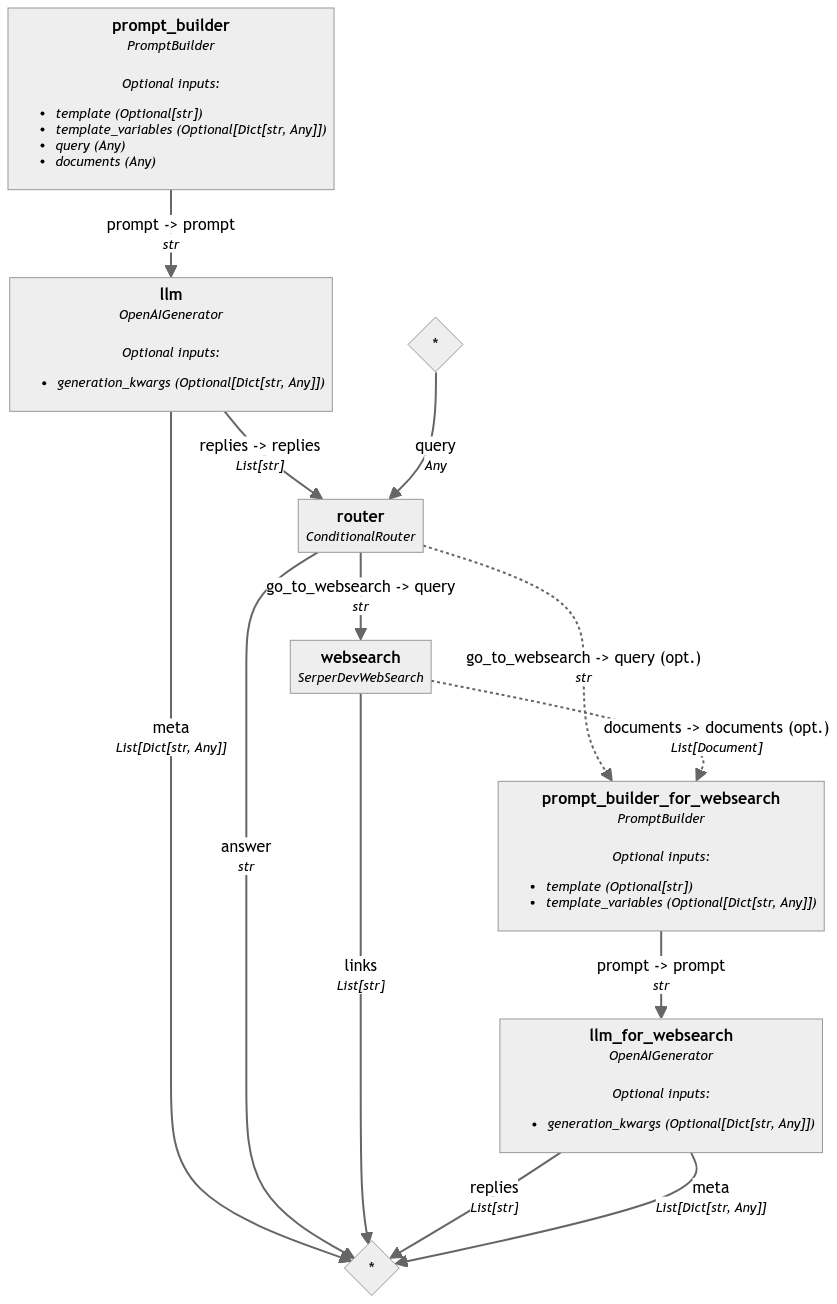

In [15]:
from utils.draw_pipeline import draw_and_display

draw_and_display(pipe, "ex09_1_pipe.png")

In [46]:
# 定義查詢
query = "慕尼黑在哪裡？"

# 運行管道
result = pipe.run({
    "prompt_builder": {
        "query": query,
        "documents": documents
    },
    "router": {"query": query}
})

# 輸出來自 ConditionalRouter 的 `answer`
print(result["router"]["answer"])
# ✅ 答案可以在定義的文件中找到。

慕尼黑是德國南部巴伐利亞州的首府，位於伊薩爾河畔。


In [49]:
# 定義查詢
query = "世界最大的啤酒節在哪裡舉行？"

# 運行管道
result = pipe.run({
    "prompt_builder": {
        "query": query,
        "documents": documents
    },
    "router": {"query": query}
})

# 輸出使用網絡搜索文件生成的 `replies`
print(result["llm_for_websearch"]["replies"])

# 查看完整結果，你將看到網絡搜索組件還提供了從網上檢索到的文件鏈接：
print(result)

{'llm': {'meta': [{'model': 'gpt-4-turbo-2024-04-09', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 24, 'prompt_tokens': 568, 'total_tokens': 592}}]}, 'router': {'answer': '世界最大的啤酒節在慕尼黑舉行。'}}


重新定義數據

In [53]:
# 定義一個新的文件，內容是維基百科對於台灣的描述
documents_tw = [
    Document(
        content="臺灣（俗字寫作台灣），西方國家亦稱福爾摩沙（葡萄牙語：Formosa），是位於東亞、太平洋西北側的島嶼，地處琉球群島與菲律賓群島之間，西隔臺灣海峽與中國大陸相望，海峽距離約130公里，周圍海域從3點鐘方向以順時鐘排序分別為太平洋（菲律賓海）、巴士海峽、南海、臺灣海峽、東海。面積約3.6萬平方公里，在當前全球各島嶼面積排名中位居第38（或39），島上約七成面積之地形為山地與丘陵，平原主要集中於西部沿海，地形海拔變化大，最高點3952公尺。全島被北回歸線貫穿，氣候炎熱，夏季偏長，介於熱帶與亞熱帶地帶之間，北回歸線以北為副熱帶季風氣候、以南為熱帶季風氣候[6][7]，自然景觀與生態系資源豐富多元[8]。臺灣面積約3.6萬平方公里，在當前全球各島嶼面積排名中位居第38（或39），為板塊碰撞隆起形成的大陸島，是東亞島弧之一部分（由菲律賓板塊潛入歐亞板塊形成）。島上約七成面積之地形為山地與丘陵，平原主要集中於西部沿海，地形海拔變化大，最高點3952公尺。全島被北回歸線貫穿，氣候炎熱，夏季偏長，介於熱帶與亞熱帶地帶之間，北回歸線以北為副熱帶季風氣候、以南為熱帶季風氣候[9][10]，自然景觀與生態系資源豐富多元[8]。人口約2300萬人，超過七成集中於西部的五大都會區，其中以行政中心臺北為核心的臺北都會區最大，約700萬人。族群構成以漢族、原住民族為主：原住民族由多個屬於南島民族的部族組成，漢族則依民系及移民年代的不同而分為閩南（河洛）、客家與外省族群，其中閩南裔為臺灣最大族群。約三萬年前冰河時期開始有人類遷移至台灣活動，自古為原住民族世居之地[11]，原住民族在17世紀中葉以前一直居於主體民族地位；隨著漢族不斷從中國大陸移入與墾殖，漢族遂取代原住民族成為臺灣的最大民族。自有信史記錄以來，臺灣歷史上曾經歷多個原住民聯盟和政權、荷西時期、明鄭時期、清治時期、日治時期等多次政權遞嬗，最近一次為1945年進入戰後時期由中華民國統治。1949年中華民國政府播遷臺灣造成兩岸分治的局面後，臺灣成為中華民國有效統治領土的主要部分[d]。隨著1987年戒嚴時代結束，臺灣逐漸淡化過往戒嚴時代形塑的中國史觀，政治上走向自由化與民主化，以中國國民黨及民主進步黨兩黨為首的政黨政治、統獨議題、以及公民社會的形成，加之以東南亞新住民的定居，產生出多元文化主義[12][13]，使得臺灣文化呈現多元並立的面貌。而由此原因再加上一中原則，使得現今「臺灣」成為中華民國的通稱。歷經1860年臺灣開港以來至日治時期所打下的現代化基礎[14]，以及中華民國政府遷臺後運用美援所進行的一系列的經濟建設，加上國際上冷戰對峙的格局，臺灣自1960年代起在經濟與社會發展上突飛猛進，締造「臺灣奇蹟」，名列亞洲四小龍之一；之後在1990年代躋身已開發國家之列，目前無論人均所得或人類發展指數均具世界先進國家水準[15]。臺灣擁有蓬勃的製造業及尖端科技，在半導體、資訊科技、通訊、電子精密製造等領域執牛耳。貿易方面主要透過高科技產業賺取外匯，經濟發展上以高科技產業與服務業為中心，亦朝向文化產業及觀光業發展[16]。台灣以移民為主的人文結構，亦帶來多元的政治觀點。自大航海時代以來，台灣文化就在明鄭、清朝的統治與西方列強的衝擊中經歷多次大變動，並在近代開始產生臺灣主體意識思想。"
        # content="""慕尼黑是德國南部巴伐利亞州的首府，充滿了豐富的文化遺產和現代城市的優雅。位於伊薩爾河畔，慕尼黑以其華麗的建築而聞名，如馬麗恩廣場的慕尼黑新市政廳和寧芬堡宮的宏偉壯觀。這座城市是藝術愛好者的天堂，擁有世界級的博物館，如阿爾特·皮納科特克，收藏了許多著名藝術家的傑作。慕尼黑也因其熱鬧的啤酒花園而聞名，當地人和遊客聚集在這裡享受城市著名的啤酒和傳統巴伐利亞美食。每年的慕尼黑啤酒節是世界上最大的啤酒節，吸引了來自世界各地的數百萬遊客。除了豐富的文化和美食享受外，慕尼黑還擁有如英國花園這樣的美麗公園，為繁忙的都市提供了一個寧靜的避風港。遊客們為慕尼黑的熱情好客所打動，使得這裡成為了想要體驗古老魅力和現代魅力的旅行者必去的目的地。"""
    )
    
]

In [75]:
# 定義查詢
query_tw = "台灣的總統是誰？"

# 運行管道
result_tw = pipe.run({
    "prompt_builder": {
        "query": query_tw,
        "documents": documents_tw
    },
    "router": {"query": query_tw}
})

# 查看完整結果
print(result_tw)

# 檢查結果是否包含本地答案
if "router" in result_tw:
    router_result = result_tw["router"]
    # 檢查是否有 router 資訊來判斷是否進行了本地檢索
    if "answer" in router_result and router_result["answer"]:
        ans = router_result["answer"]
        print(f"本地檢索存在：{ans}。")
    else:
        print("本地檢索未找到答案。")
# 假如本地無答案，檢查是否有網絡搜索結果
elif "llm_for_websearch" in result_tw:
    llm_for_websearch_result = result_tw["llm_for_websearch"]
    if "replies" in llm_for_websearch_result and llm_for_websearch_result["replies"]:
        print("網絡搜索答案:", llm_for_websearch_result["replies"])
    else:
        print("進行網絡搜索但未找到答案。")
else:
    print("本地與網路搜索皆無結果。")

# 檢查 router 結果
if "router" in result_tw and "answer" in result_tw["router"]:
    print("Router 在本地文本有找到答案:", result_tw["router"]["answer"])
else:
    print("Router 在本地文本未找到答案，並將 query 傳遞給 websearch")


{'llm': {'meta': [{'model': 'gpt-4-turbo-2024-04-09', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 2, 'prompt_tokens': 2000, 'total_tokens': 2002}}]}, 'websearch': {'links': ['https://zh.wikipedia.org/zh-cn/%E4%B8%AD%E8%8F%AF%E6%B0%91%E5%9C%8B%E7%B8%BD%E7%B5%B1', 'https://zh.wikipedia.org/zh-hant/%E4%B8%AD%E8%8F%AF%E6%B0%91%E5%9C%8B%E7%B8%BD%E7%B5%B1', 'https://www.president.gov.tw/Page/81', 'https://www.bbc.com/zhongwen/trad/chinese-news-67978429', 'https://cn.wsj.com/articles/%E8%B3%B4%E6%B8%85%E5%BE%B7%E7%95%B6%E9%81%B8%E5%8F%B0%E7%81%A3%E6%96%B0%E7%B8%BD%E7%B5%B1-%E9%81%B8%E6%B0%91%E6%84%8F%E5%BF%97%E6%93%8A%E6%95%97%E5%8C%97%E4%BA%AC%E6%84%8F%E5%9C%96-e7f002d4', 'https://tw.news.yahoo.com/520%E6%AD%A3%E5%BC%8F%E5%B0%B1%E8%81%B7-%E8%B3%B4%E6%B8%85%E5%BE%B7%E7%AC%AC16%E4%BB%BB%E7%B8%BD%E7%B5%B1-%E6%AD%B7%E5%B1%86%E7%B8%BD%E7%B5%B1%E7%AB%9F%E6%98%AF-%E4%BB%96-%E4%BB%BB%E6%9C%9F%E6%9C%80%E7%9F%AD-010520794.html', 'https://www.president.gov.tw/Page/82', 'https://